<b>Zillow Scrape and data analysis </b>

The first part will run a script that will scrape and compile the housing data into csv worksheets. The default URL which is being run is for all rental properties available in Durham. Note that apartments are excluded from being saved as most of them are not available to purchase. Only townhouses and houses are saved

In [20]:
import scrapeAndCompileHousingData

In [3]:
scrapeAndCompileHousingData.main()

starting page : 0


C:\Users\Adam\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file C:\Users\Adam\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


<div class="zsg-photo-card-content zsg-aspect-ratio-content" itemscope="" itemtype="http://schema.org/SingleFamilyResidence"><span class="hide" itemprop="address" itemscope="" itemtype="http://schema.org/PostalAddress"><span itemprop="streetAddress">8022 Morrell Ln</span><span itemprop="addressLocality">Durham</span><span itemprop="addressRegion">NC</span><span class="hide" itemprop="postalCode">27713</span></span><span itemprop="geo" itemscope="" itemtype="http://schema.org/GeoCoordinates"><meta content="35.900048" itemprop="latitude"/><meta content="-78.953188" itemprop="longitude"/></span><div class="zsg-photo-card-caption"><h4 class="zsg-photo-card-spec"><span class="zsg-photo-card-status"><span class="zsg-icon-for-rent"></span>House For Rent</span></h4><p class="zsg-photo-card-spec"><span class="zsg-photo-card-price">$1,995/mo</span><span class="zsg-photo-card-info">4 bds <span class="interpunct">·</span> 3 ba <span class="interpunct">·</span> 2,750 sqft</span></p><p class="zsg-ph

KeyboardInterrupt: 

Currently a number of csv sheets have been saved based on information using the Zillow API.

<b>Data Visualization: price</b>

In [91]:
import pandas as pd
import numpy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.stats.api import ols

In [138]:

house_data = pd.read_csv('allDurhamDataWithCoords.csv', index_col=0, thousands=',')
X = house_data[['bedrooms', 'bathrooms', 'sqft']]
house_price = house_data['zestimate']
house_rent = house_data['real rent']
house_price_rent_ratio = house_rent / house_price
house_data['rentToPrice'] = house_price_rent_ratio
house_data.head(3)

,zipcode,address,latitude,longitude,zpid,bathrooms,bedrooms,sqft,homtype,taxAssessmentYear,taxAssessment,zestimate,rentzestimate,real rent,rentToPrice
city,,,,,,,,,,,,,,,
Durham,27703,511 Callandale Ln,35.959758,-78.833002,119255227,3.5,5,3255,SingleFamily,2014,47999.0,322568.0,1800,2295,0.007115
Durham,27705,2508 Richwood Rd,36.040446,-78.919083,49985222,1.0,2,760,SingleFamily,2014,75676.0,107075.0,1100,1125,0.010507
Durham,27713,8022 Morrell Ln,35.900048,-78.953188,70923894,3.0,4,2750,SingleFamily,2015,317759.0,311853.0,1895,1995,0.006397


In [139]:
sortedByBedrooms = [];
numBedrooms = [];
#This for loop is here to sort the bedroom data into lists based on number of bedrooms
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_data.zestimate[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)

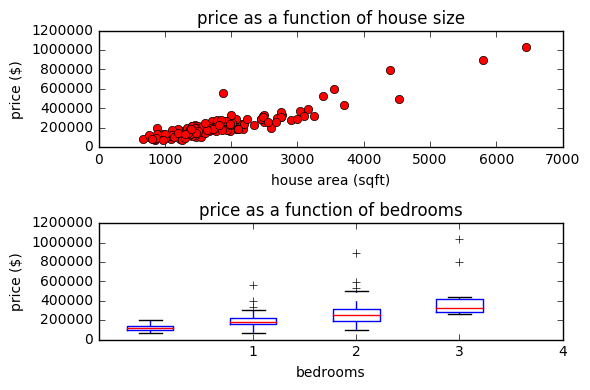

In [140]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('price ($)')
plt.title('price as a function of bedrooms')
plt.xticks(numBedrooms)
plt.tight_layout()
plt.show()

From the figures above we can see that 1 bedroom houses might need to be culled as well as the house with the way more square footage than comparable houses

In [141]:
mask = numpy.array(X['sqft']<15000) & numpy.array(X['bedrooms']>1) & numpy.array(house_price>1)

In [142]:
X = X[mask]
house_price = house_price[mask]
house_rent = house_rent[mask]
house_price_rent_ratio = house_price_rent_ratio[mask]
house_data = house_data[mask]

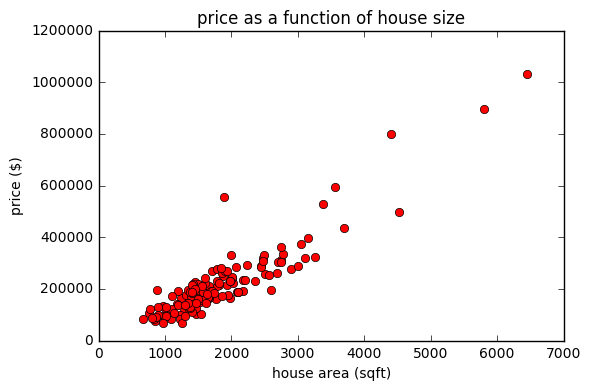

In [143]:
plt.plot(X['sqft'], house_price, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('price as a function of house size')
plt.show()

The house price per sqft looks better and more linear with outlier removed

Normalizing data before fitting a linear regression curve

In [144]:
for column_name in X.keys():
    house_data[column_name + '_norm'] = (X[column_name] - numpy.mean(X[column_name])) / numpy.std(X[column_name])

In [145]:
Xnorm = house_data[['bedrooms_norm', 'bathrooms_norm', 'sqft_norm']]

In [146]:
est = sm.OLS(house_price, Xnorm).fit()

In [147]:
est.params

bedrooms_norm     -23031.698607
bathrooms_norm      -382.321675
sqft_norm         139686.860446
dtype: float64

The results above are really weird... it would appear that house price goes down with increasing bedrooms and bathrooms. This could indicate that a large house with fewer bedrooms is worth more than a small house with more bedrooms... 

                            OLS Regression Results                            
Dep. Variable:              zestimate   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     722.6
Date:                Tue, 17 Jan 2017   Prob (F-statistic):           5.06e-59
Time:                        09:48:19   Log-Likelihood:                -1864.6
No. Observations:                 151   AIC:                             3733.
Df Residuals:                     149   BIC:                             3739.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       2.156e+05   4571.709     47.154      0.0

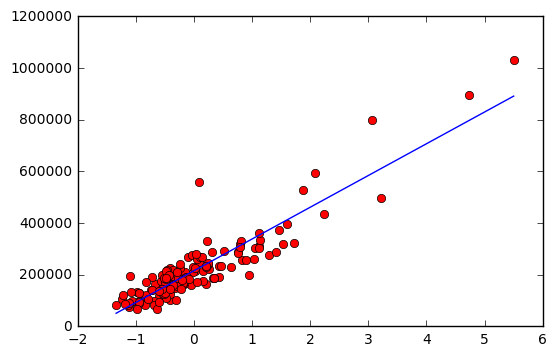

In [148]:
x = sm.add_constant(Xnorm['sqft_norm'])
estSingle = sm.OLS(house_price, x).fit()
print(estSingle.summary())
x_pred = numpy.linspace(numpy.min(Xnorm['sqft_norm']),numpy.max(Xnorm['sqft_norm']),50)
x_pred2 = sm.add_constant(x_pred)
y_pred = estSingle.predict(x_pred2)
plt.plot(Xnorm['sqft_norm'], house_price, 'ro')
plt.plot(x_pred, y_pred)
plt.show()

                            OLS Regression Results                            
Dep. Variable:              zestimate   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     73.00
Date:                Tue, 17 Jan 2017   Prob (F-statistic):           1.41e-14
Time:                        09:48:20   Log-Likelihood:                -1967.9
No. Observations:                 151   AIC:                             3940.
Df Residuals:                     149   BIC:                             3946.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          2.156e+05   9058.422     23.798

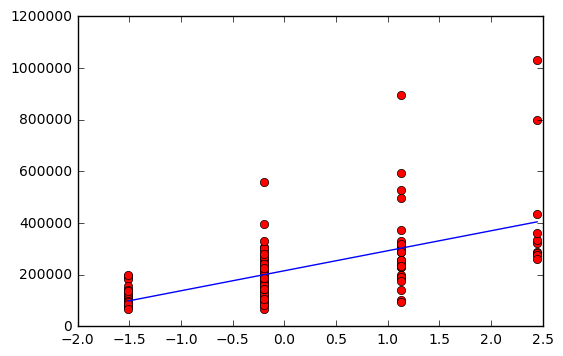

In [149]:
x = sm.add_constant(Xnorm['bedrooms_norm'])
estSingle = sm.OLS(house_price, x).fit()
print(estSingle.summary())
x_pred = numpy.linspace(numpy.min(Xnorm['bedrooms_norm']),numpy.max(Xnorm['bedrooms_norm']),50)
x_pred2 = sm.add_constant(x_pred)
y_pred = estSingle.predict(x_pred2)
plt.plot(Xnorm['bedrooms_norm'], house_price, 'ro')
plt.plot(x_pred, y_pred)
plt.show()

                            OLS Regression Results                            
Dep. Variable:              zestimate   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     41.36
Date:                Tue, 17 Jan 2017   Prob (F-statistic):           1.63e-09
Time:                        09:48:20   Log-Likelihood:                -1979.5
No. Observations:                 151   AIC:                             3963.
Df Residuals:                     149   BIC:                             3969.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const           2.156e+05   9782.526     22.

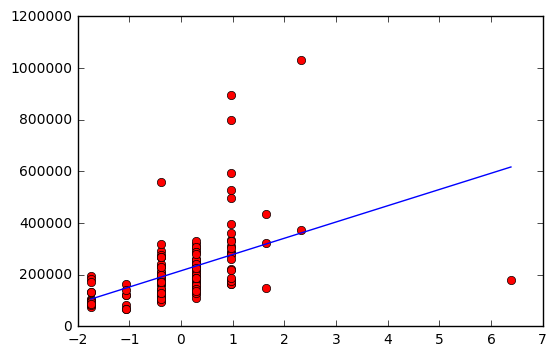

In [150]:
x = sm.add_constant(Xnorm['bathrooms_norm'])
estSingle = sm.OLS(house_price, x).fit()
print(estSingle.summary())
x_pred = numpy.linspace(numpy.min(Xnorm['bathrooms_norm']),numpy.max(Xnorm['bathrooms_norm']),50)
x_pred2 = sm.add_constant(x_pred)
y_pred = estSingle.predict(x_pred2)
plt.plot(Xnorm['bathrooms_norm'], house_price, 'ro')
plt.plot(x_pred, y_pred)
plt.show()

Above is a sanity check to ensure that each individual parameter acts as we would expect individually

<b>Data Visualization: price to rent</b>

In [151]:
sortedByBedrooms = [];
numBedrooms = [];
for i in sorted(house_data.bedrooms.unique()):
    numBedrooms.append(i)
    valList = numpy.array(list(house_price_rent_ratio[list(house_data.bedrooms == i)]))
    valList = valList[~numpy.isnan(valList)]
    sortedByBedrooms.append(valList)

In [152]:
numBedrooms

[2, 3, 4, 5]

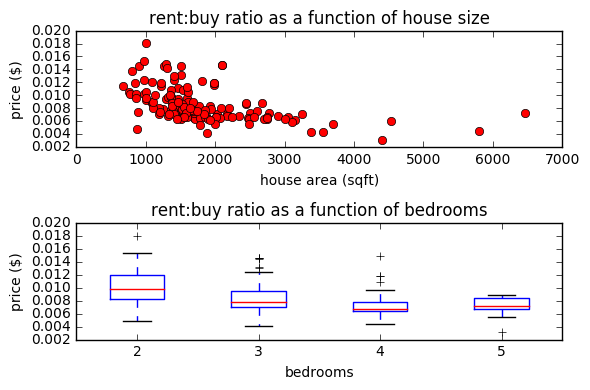

In [153]:
plt.subplot(2,1,1)
plt.plot(X['sqft'], house_price_rent_ratio, 'ro')
plt.xlabel('house area (sqft)')
plt.ylabel('price ($)')
plt.title('rent:buy ratio as a function of house size')
plt.subplot(2,1,2)
plt.boxplot(sortedByBedrooms)
plt.xticks(range(1,5), numBedrooms)
plt.xlabel('bedrooms')
plt.ylabel('price ($)')
plt.title('rent:buy ratio as a function of bedrooms')

plt.tight_layout()
plt.show()

From the figures above it seems as though we can see a weak trend that would indicate that for a rent/price ratio. It looks as though a smaller, fewer bedrooms will results in best rent returns

In [154]:
house_data = house_data.sort(columns = 'rentToPrice', ascending = False)

C:\Users\Adam\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [155]:
best_rent_to_price = house_data.head(10)

In [156]:
best_rent_to_price

,zipcode,address,latitude,longitude,zpid,bathrooms,bedrooms,sqft,homtype,taxAssessmentYear,taxAssessment,zestimate,rentzestimate,real rent,rentToPrice,bedrooms_norm,bathrooms_norm,sqft_norm
city,,,,,,,,,,,,,,,,,,
Durham,27713,5500 Fortunes Ridge Dr APT 72D,35.924458,-78.928483,50001335,2.0,2,1007,Condominium,2014,116567.0,130122.0,1100,2350,0.018060,-1.511162,-0.390405,-0.942587
Durham,27701,19 Hayti Ln,35.984967,-78.896843,49980199,1.5,2,970,SingleFamily,2014,53945.0,68367.0,900,1050,0.015358,-1.511162,-1.068006,-0.986342
Durham,27707,401 Moline St,35.978339,-78.902403,49978896,2.0,4,1296,SingleFamily,2014,80507.0,94156.0,1150,1400,0.014869,1.126820,-0.390405,-0.600827
Durham,27704,110 Parsons Green Ct,36.061381,-78.913890,98189248,2.5,3,2100,SingleFamily,2014,170356.0,187859.0,1895,2750,0.014639,-0.192171,0.287195,0.349952
Durham,27704,108 Parsons Green Ct,36.061533,-78.913809,98185005,2.5,3,2100,SingleFamily,2014,170322.0,188055.0,1950,2750,0.014623,-0.192171,0.287195,0.349952
Durham,27713,1003 Crimson Dr,35.915014,-78.916042,70923539,2.5,3,1500,Townhouse,2014,155346.0,161045.0,1350,2350,0.014592,-0.192171,0.287195,-0.359585
Durham,27701,213 Northwood Cir,36.002704,-78.897148,49969810,1.0,2,900,SingleFamily,2015,54924.0,99549.0,1395,1450,0.014566,-1.511162,-1.745606,-1.069121
Durham,27707,800 Fargo St APT A3,35.986255,-78.907699,49980319,1.5,3,1260,Townhouse,2014,60118.0,69190.0,1025,1000,0.014453,-0.192171,-1.068006,-0.643399
Durham,27713,2717 Wyntercrest Ln,35.942859,-78.890328,80204336,2.5,2,1300,Townhouse,2014,133969.0,137842.0,1250,1950,0.014147,-1.511162,0.287195,-0.596097


In [169]:
import codecs
fhand = codecs.open('where.js','w', "utf-8")
fhand.write("myData = [\n")
count = 0
for entry in best_rent_to_price.iterrows():
    lat = entry[1][2]
    lng = entry[1][3]
    where = entry[1][1]
    if count > 1 : fhand.write(",\n")
    output = "["+str(lat)+","+str(lng)+", '"+where+"'],"
    fhand.write(output)
    
fhand.write("\n];\n")
fhand.close()

In [205]:
from IPython.display import display
from IPython.display import HTML
from IPython.display import IFrame
#HTML('<iframe src="./where.html" width=1000 height=1000></iframe>')
IFrame('where.html', width=700, height=500)